Importing all the necessary packages

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

Loading and looking at our dataset

In [6]:
# Load the dataset
df = pd.read_csv(r'C:\Users\Blen\OneDrive\Documents\10Academy\Week1\Data\raw_analyst_ratings.csv')

# Display the first few rows
df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


Checking if there is a null value

In [7]:
print(df.isnull().sum())

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64


In [8]:
df.shape

(1048575, 6)

Headline length analysis

count    1.048575e+06
mean     7.300076e+01
std      4.029646e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


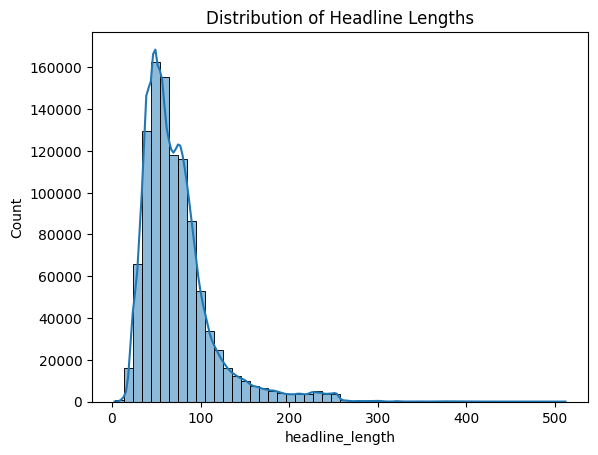

In [11]:
# Add a column for headline length
df['headline_length'] = df['headline'].apply(len)

# Get basic statistics
headline_stats = df['headline_length'].describe()
print(headline_stats)

# Plot the distribution of headline lengths
sns.histplot(df['headline_length'], bins=50, kde=True)
plt.title('Distribution of Headline Lengths')
plt.show()


Counting the articles per publisher

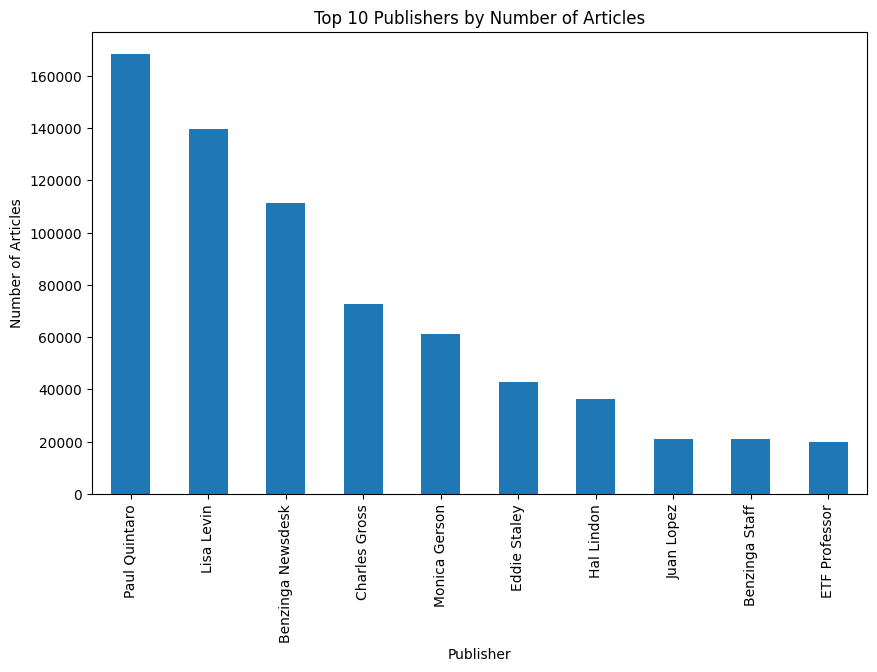

In [12]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

# Plot the top 10 publishers
publisher_counts.head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.show()

Analyzing Publication Date Trends over Time

In [19]:
#Converting the date to an appropriate format
df['date'] = pd.to_datetime(df['date'], format="%m/%d/%Y %H:%M", utc=True)


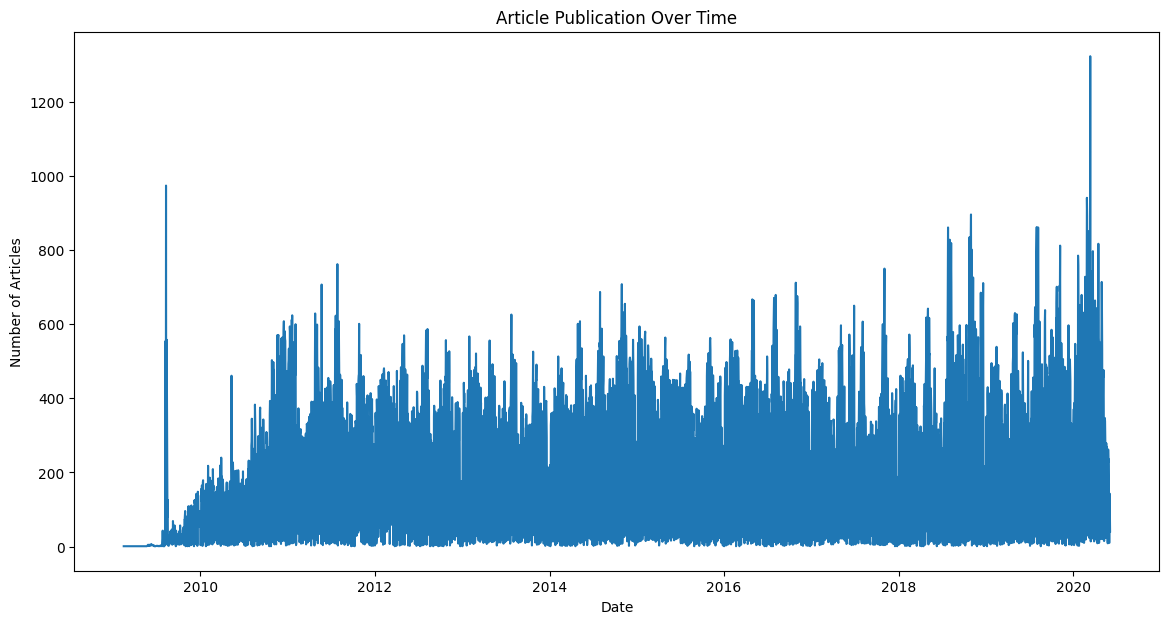

In [17]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Group by date and count articles
date_counts = df.groupby(df['date'].dt.date).size()

# Plot the time series
plt.figure(figsize=(14, 7))
date_counts.plot()
plt.title('Article Publication Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()


Detailed Time Series Analysis(analyzing trends, seasonality, and residuals on a monthly scale, providing insights into how the frequency of articles varies from month to month for every year.)

C:\Users\Blen\AppData\Local\Temp\ipykernel_1456\1066743701.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.resample('M', on='date').size()


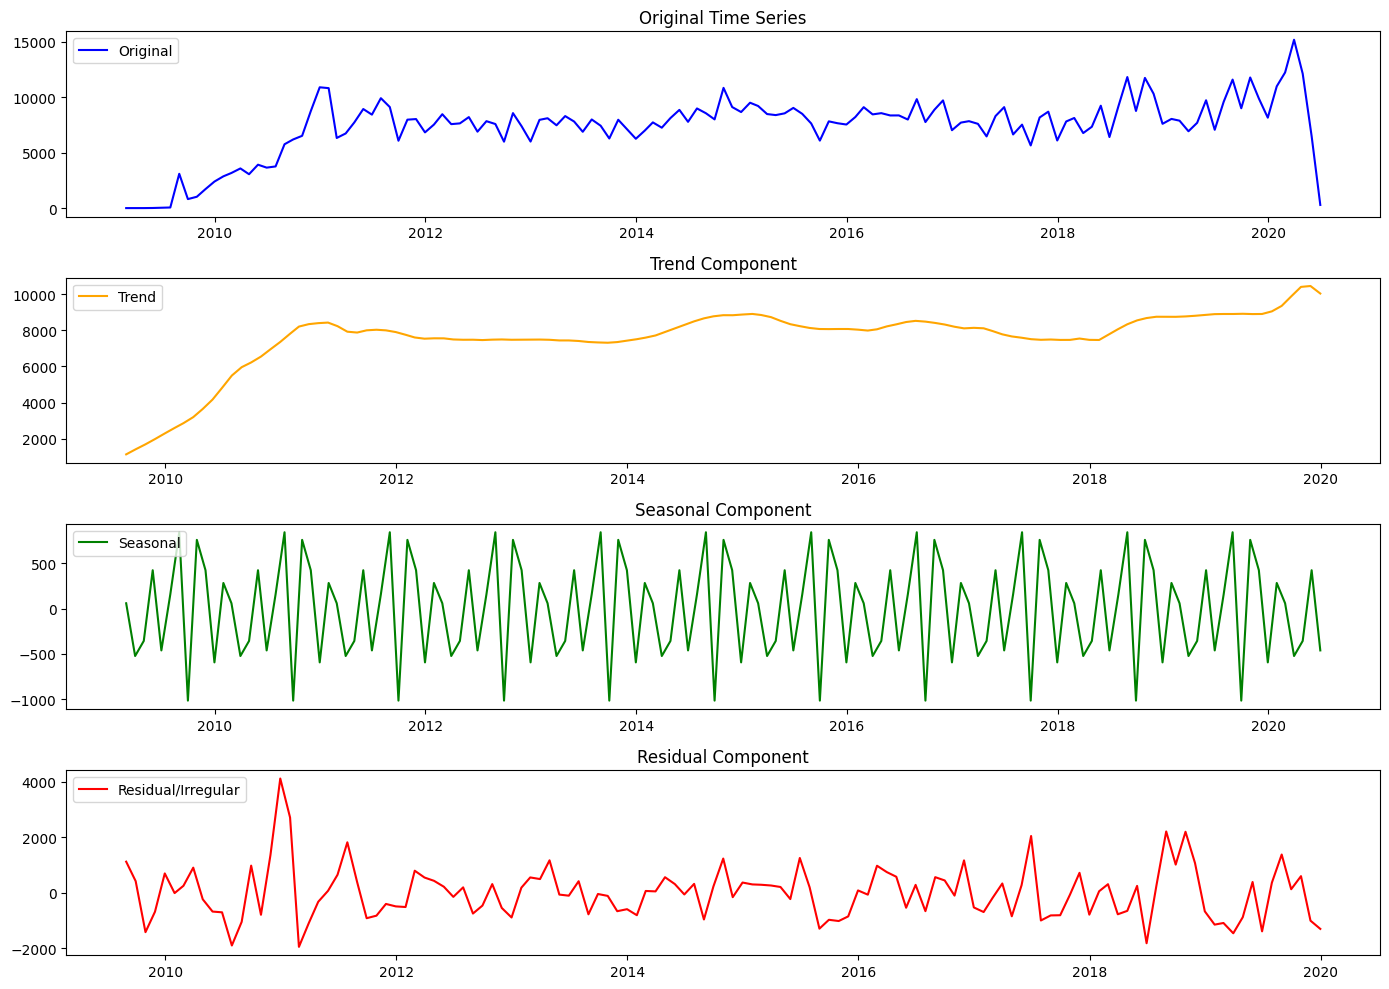

In [27]:

# Resample data by month (use 'M' for end of month, 'MS' for start of month)
monthly_counts = df.resample('M', on='date').size()

# Perform seasonal decomposition (period=12 for monthly data, assuming yearly seasonality)
decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)

# Plot the components
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(monthly_counts, label='Original', color='blue')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual/Irregular', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()




Performing Sentiment Analysis on the Headlines

In [30]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Blen\AppData\Roaming\nltk_data...


True

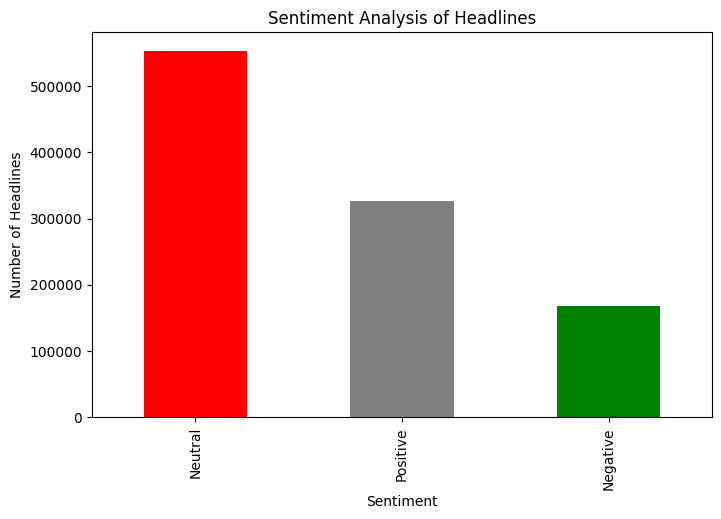

In [31]:
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['sentiment'] = df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Classify sentiment as positive, neutral, or negative
df['sentiment_label'] = pd.cut(df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

# Display the sentiment distribution
sentiment_counts = df['sentiment_label'].value_counts()
sentiment_counts.plot(kind='bar', figsize=(8, 5), color=['red', 'grey', 'green'])
plt.title('Sentiment Analysis of Headlines')
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.show()


Determining which publisher generates more negative, positive, and neutral articles

In [32]:

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment label from compound score
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to each headline
df['compound_score'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['compound_score'].apply(get_sentiment_label)

# Aggregating sentiment counts by publisher
sentiment_counts = df.groupby(['publisher', 'sentiment']).size().unstack(fill_value=0)

# Identifying the publisher with the most articles of each sentiment type
most_positive = sentiment_counts['positive'].idxmax()
most_negative = sentiment_counts['negative'].idxmax()
most_neutral = sentiment_counts['neutral'].idxmax()

print("Publisher with most positive articles:", most_positive)
print("Publisher with most negative articles:", most_negative)
print("Publisher with most neutral articles:", most_neutral)

#printing the counts for more details
print("\nSentiment counts by publisher:")
print(sentiment_counts)


Publisher with most positive articles: Paul Quintaro
Publisher with most negative articles: Benzinga Newsdesk
Publisher with most neutral articles: Paul Quintaro

Sentiment counts by publisher:
sentiment                   negative  neutral  positive
publisher                                              
AARP                               0        6         0
ABNNewswire                        3        3         5
Aakin                              0        2         2
Aaron Jackson.Ed                   1        0        10
Aaron Levitt                      18      116        95
...                              ...      ...       ...
vic@forextraininggroup.com         0        1         0
vishwanath@benzinga.com          661      510       226
vivek.proactive@gmail.com         33       40        13
wallstreet1928                     1        5         1
webmaster                       2521     9212      3498

[984 rows x 3 columns]


Sentiment Distribution Across the Top 10 Publishers with the Highest Total Number of Articles

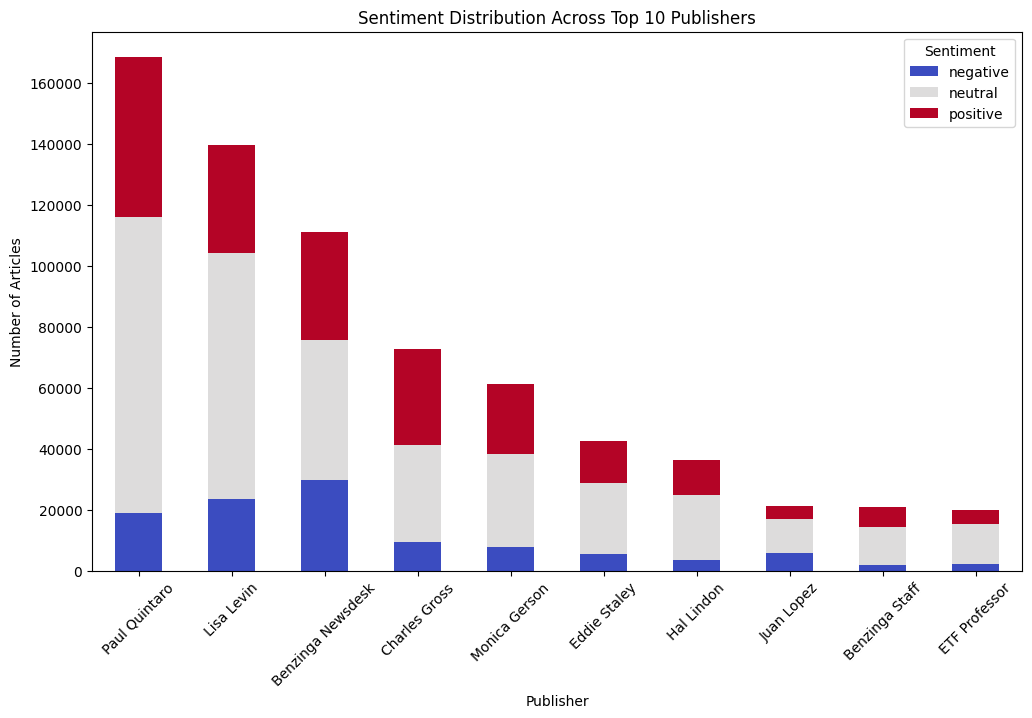

In [40]:

# Group by publisher and sentiment, and count the number of articles
publisher_sentiment = df.groupby(['publisher', 'sentiment']).size().unstack(fill_value=0)

# Calculate total articles per publisher
total_articles_per_publisher = publisher_sentiment.sum(axis=1)

# Get top 10 publishers with the most articles
top_10_publishers = total_articles_per_publisher.nlargest(10).index

# Filter the publisher_sentiment DataFrame to include only top 10 publishers
top_publishers_sentiment = publisher_sentiment.loc[top_10_publishers]

# Plot the sentiment distribution for top 10 publishers
top_publishers_sentiment.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='coolwarm')
plt.title('Sentiment Distribution Across Top 10 Publishers')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()


Domain Analysis (Extracting unique domains from publisher names)

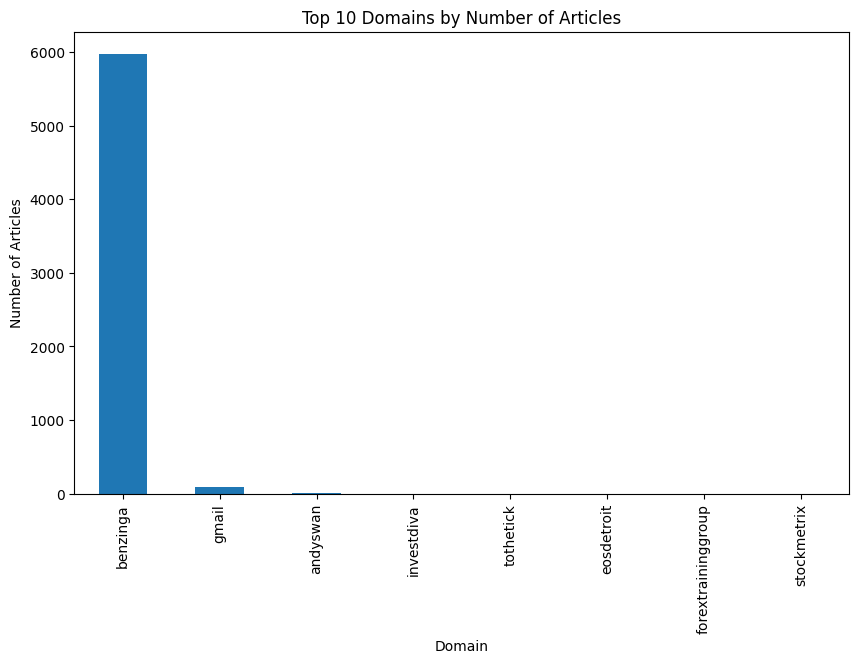

In [39]:
# Extract domain names from publisher emails
df['domain'] = df['publisher'].str.extract(r'@([^.]+)\.')

# Count articles by domain
domain_counts = df['domain'].value_counts()

# Plot the top domains
domain_counts.head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Domains by Number of Articles')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.show()


Getting the top 10 stocks with the highest counts of positive, negative, and neutral scores, you can follow these steps:

In [33]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment label from compound score
def get_sentiment_label(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to each headline
df['compound_score'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['compound_score'].apply(get_sentiment_label)

# Aggregate sentiment counts by stock
sentiment_counts = df.groupby(['stock', 'sentiment']).size().unstack(fill_value=0)

# Get top 10 stocks for each sentiment type
top_positive_stocks = sentiment_counts.sort_values('positive', ascending=False).head(10)
top_negative_stocks = sentiment_counts.sort_values('negative', ascending=False).head(10)
top_neutral_stocks = sentiment_counts.sort_values('neutral', ascending=False).head(10)

# Display results
print("Top 10 stocks with the most positive articles:")
print(top_positive_stocks[['positive']])

print("\nTop 10 stocks with the most negative articles:")
print(top_negative_stocks[['negative']])

print("\nTop 10 stocks with the most neutral articles:")
print(top_neutral_stocks[['neutral']])


Top 10 stocks with the most positive articles:
sentiment  positive
stock              
CHK            1299
GILD           1105
MU             1094
NFLX           1085
MRK            1077
EBAY           1074
NVDA           1064
BABA           1062
M              1049
QCOM            991

Top 10 stocks with the most negative articles:
sentiment  negative
stock              
EWU             693
MRK             643
EWP             641
MS              601
MU              589
GLD             560
JNJ             523
DAL             512
FDX             506
M               503

Top 10 stocks with the most neutral articles:
sentiment  neutral
stock             
MS            1684
NVDA          1616
MRK           1613
AA            1525
EBAY          1524
NFLX          1502
ORCL          1493
EWJ           1489
HD            1479
M             1473


Topic Modelling or Key word Extraction

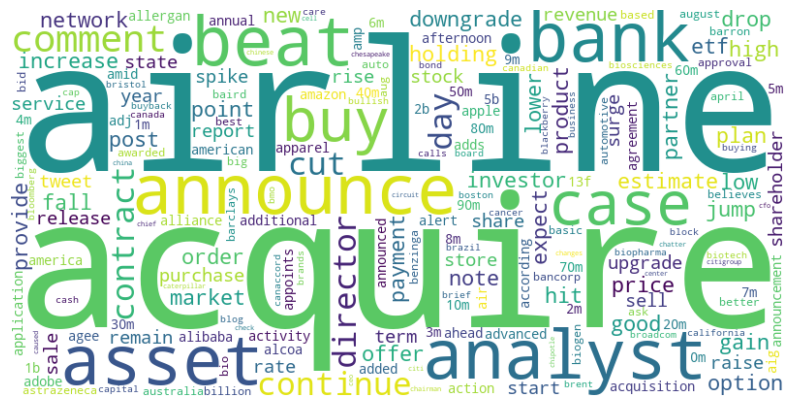

In [34]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Fit and transform the headlines
X = vectorizer.fit_transform(df['headline'])

# Create a DataFrame with keywords
keywords = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(keywords.columns))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
